In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
%matplotlib inline

In [2]:
with open('names.txt') as f:
    words = f.read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {ch: i+1 for i, ch in enumerate(chars)}
stoi['$'] = 0
itos = {i: ch for ch, i in stoi.items()}

In [5]:
block_size = 3  # context

X, Y = [], []

for word in words[:3]:
    print(word)
    context = [0] * block_size

    for ch in word + "$":
        X.append(context)
        Y.append(stoi[ch])
        print("".join([itos[i] for i in context]), "--->", ch)
        context = context[1:] + [stoi[ch]]

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
$$$ ---> e
$$e ---> m
$em ---> m
emm ---> a
mma ---> $
olivia
$$$ ---> o
$$o ---> l
$ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> $
ava
$$$ ---> a
$$a ---> v
$av ---> a
ava ---> $


In [6]:
X.shape, Y.shape

(torch.Size([16, 3]), torch.Size([16]))

In [7]:
# per character embedding
emb = torch.randn((27, 2))

In [8]:
for ch in chars[:5]:
    print(ch, emb[stoi[ch]])

a tensor([0.5514, 0.6251])
b tensor([1.4787, 1.4839])
c tensor([0.3322, 1.9561])
d tensor([-2.4334, -0.9214])
e tensor([ 0.6263, -0.4940])


In [9]:
emb[X].shape

torch.Size([16, 3, 2])

In [10]:
emb[X].view(-1,6)

tensor([[-0.4256, -0.2855, -0.4256, -0.2855, -0.4256, -0.2855],
        [-0.4256, -0.2855, -0.4256, -0.2855,  0.6263, -0.4940],
        [-0.4256, -0.2855,  0.6263, -0.4940,  1.5738, -0.2372],
        [ 0.6263, -0.4940,  1.5738, -0.2372,  1.5738, -0.2372],
        [ 1.5738, -0.2372,  1.5738, -0.2372,  0.5514,  0.6251],
        [-0.4256, -0.2855, -0.4256, -0.2855, -0.4256, -0.2855],
        [-0.4256, -0.2855, -0.4256, -0.2855, -0.4661, -0.6191],
        [-0.4256, -0.2855, -0.4661, -0.6191, -0.5299,  0.8688],
        [-0.4661, -0.6191, -0.5299,  0.8688,  0.0991,  0.0444],
        [-0.5299,  0.8688,  0.0991,  0.0444,  0.7078,  1.2652],
        [ 0.0991,  0.0444,  0.7078,  1.2652,  0.0991,  0.0444],
        [ 0.7078,  1.2652,  0.0991,  0.0444,  0.5514,  0.6251],
        [-0.4256, -0.2855, -0.4256, -0.2855, -0.4256, -0.2855],
        [-0.4256, -0.2855, -0.4256, -0.2855,  0.5514,  0.6251],
        [-0.4256, -0.2855,  0.5514,  0.6251,  0.7078,  1.2652],
        [ 0.5514,  0.6251,  0.7078,  1.2

In [11]:
w1 = torch.randn(6, 100)
b1 = torch.randn(100)
w2 = torch.randn(100, 27)
b2 = torch.randn(27)

In [12]:
h = F.tanh(emb[X].view(-1,6) @ w1 + b1)
h.shape

torch.Size([16, 100])

In [13]:
logits = h @ w2 + b2
logits.shape

torch.Size([16, 27])

In [14]:
prob = F.softmax(logits, dim=1)
prob.shape

torch.Size([16, 27])

In [15]:
prob.sum(1).shape

torch.Size([16])

## Re writing everything for training

In [16]:
# Data preprosessing
with open('names.txt') as f:
    words = f.read().splitlines()

chars = sorted(list(set(''.join(words))))
stoi = {ch: i+1 for i, ch in enumerate(chars)}
stoi['$'] = 0
itos = {i: ch for ch, i in stoi.items()}

block_size = 3  # context

X, Y = [], []

for word in words:
    context = [0] * block_size

    for ch in word + "$":
        X.append(context)
        Y.append(stoi[ch])
        context = context[1:] + [stoi[ch]]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [17]:
# Model weights and biases

emb_space = 2
hidden = 100
char_size = len(stoi)

g = torch.Generator().manual_seed(214_748_3647)
emb = torch.randn((char_size, emb_space), generator=g)
W1 = torch.randn((block_size * emb_space, hidden), generator=g)
b1 = torch.randn(hidden, generator=g)
W2 = torch.randn((hidden, char_size), generator=g)
b2 = torch.randn(char_size, generator=g)

parameters = [emb, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad_()

In [23]:
for iter in range(10000):
    # mini-batch
    idx = torch.randint(0, len(X), (32,))
    x = X[idx]
    y = Y[idx]
    
    # Forward pass
    h = F.tanh(emb[x].view(-1, block_size * emb_space) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)

    for p in parameters:
        p.grad = None

    # Backward pass
    loss.backward()

    # Update weights
    for p in parameters:
        p.data -= 0.0001 * p.grad

    if iter % 100 == 0:
        h = F.tanh(emb[X].view(-1, block_size * emb_space) @ W1 + b1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Y)
        print(loss.item())

2.3799335956573486
2.3799326419830322
2.379940986633301
2.379932165145874
2.3799281120300293
2.3799383640289307
2.3799383640289307
2.3799455165863037
2.3799567222595215
2.3799502849578857
2.3799455165863037
2.3799493312835693
2.379934787750244
2.3799219131469727
2.3799126148223877
2.3799054622650146
2.3799021244049072
2.379899501800537
2.3798930644989014
2.3798937797546387
2.3798959255218506
2.379890203475952
2.379889488220215
2.3798885345458984
2.379884719848633
2.379892587661743
2.3798887729644775
2.3798820972442627
2.3798842430114746
2.3798828125
2.3798863887786865
2.3798794746398926
2.379878282546997
2.3798787593841553
2.3798813819885254
2.379868268966675
2.379871129989624
2.379871129989624
2.379873514175415
2.379871129989624
2.379882574081421
2.37988018989563
2.3798794746398926
2.379892587661743
2.379892587661743
2.3798837661743164
2.3798820972442627
2.3798673152923584
2.379866600036621
2.3798599243164062
2.3798575401306152
2.379854679107666
2.379847288131714
2.3798398971557617
2.

# Final Code

In [43]:
# Data preprosessing 
block_size = 3  # context
split_ratio = 0.8

with open('names.txt') as f:
    words = f.read().splitlines()

chars = sorted(list(set(''.join(words))))
stoi = {ch: i+1 for i, ch in enumerate(chars)}
stoi['$'] = 0
itos = {i: ch for ch, i in stoi.items()}


X, Y = [], []

for word in words:
    context = [0] * block_size

    for ch in word + "$":
        X.append(context)
        Y.append(stoi[ch])
        context = context[1:] + [stoi[ch]]

X = torch.tensor(X)
Y = torch.tensor(Y)

X_train, X_valid = X[:int(len(X) * split_ratio)], X[int(len(X) * split_ratio):]
Y_train, Y_valid = Y[:int(len(Y) * split_ratio)], Y[int(len(Y) * split_ratio):]

In [44]:
# Model weights and biases
emb_space = 16
hidden = 100
char_size = len(stoi)

g = torch.Generator().manual_seed(214_748_3647)
emb = torch.randn((char_size, emb_space), generator=g)
W1 = torch.randn((block_size * emb_space, hidden), generator=g)
b1 = torch.randn(hidden, generator=g)
W2 = torch.randn((hidden, char_size), generator=g)
b2 = torch.randn(char_size, generator=g)

parameters = [emb, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad_()

In [58]:
# Training
iteration = 50_000
minbatch_size = 128

losses = []
for iter in range(iteration):
    # mini-batch
    idx = torch.randint(0, len(X_train), (minbatch_size,))
    x = X_train[idx]
    y = Y_train[idx]
    
    # Forward pass
    h = F.tanh(emb[x].view(-1, block_size * emb_space) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)

    for p in parameters:
        p.grad = None

    # Backward pass
    loss.backward()
    learning_rate = 0.005

    # Update weights
    for p in parameters:
        p.data -= learning_rate * p.grad

    if iter % 500 == 0:
        h = F.tanh(emb[X_valid].view(-1, block_size * emb_space) @ W1 + b1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Y_valid)
        losses.append(loss.item())

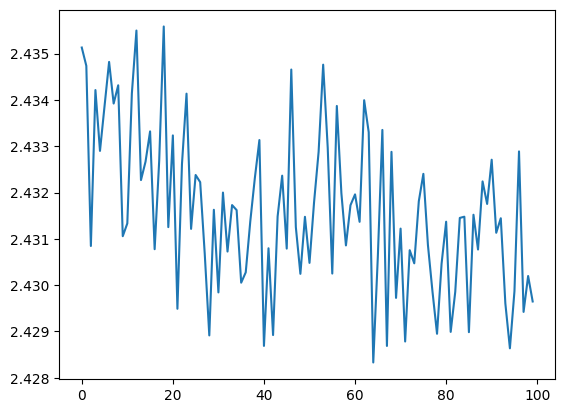

In [59]:
plt.plot(losses)

In [60]:
# Calcualte Validation Loss
h = F.tanh(emb[X_valid].view(-1, block_size * emb_space) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_valid)
loss.item()

2.431807518005371

In [61]:
# Generate names
def generate_name():
    name = ""
    context = [0] * block_size
    while True:
        x = torch.tensor(context).view(1, -1)
        h = F.tanh(emb[x].view(-1, block_size * emb_space) @ W1 + b1)
        logits = h @ W2 + b2
        prob = F.softmax(logits, dim=1)
        next_char = torch.multinomial(prob.view(-1), 1).item()
        if next_char == 0:
            break
        name += itos[next_char]
        context = context[1:] + [next_char]
    return name

for _ in range(10):
    print(generate_name())

alean
lambereth
ilia
cnizoruinn
anger
zirgena
holsyn
achi
kinzlana
far
